In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import matplotlib.pyplot as plt
from pytorch_msssim import ssim
from torchvision.utils import save_image
from pytorch_fid import fid_score
import time
import os
import re
import shutil
from torch.autograd import Variable


rebuild_path = 'rebuild'

# Verificar se a pasta existe
if os.path.exists(rebuild_path) and os.path.isdir(rebuild_path):
    # Eliminar a pasta e todo o seu conteúdo
    shutil.rmtree(rebuild_path)

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

In [2]:
train_dataset_path = 'data-students/TRAIN'

IMG_WIDTH = 75
IMG_HEIGHT = 75
BATCH_SIZE = 32

In [3]:
transform = transforms.Compose([
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),   # Redimensiona todas as imagens para 75x75 pixels
    transforms.ToTensor(),         # Converte as imagens para tensores do PyTorch
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]

])

full_dataset = datasets.ImageFolder(root=train_dataset_path, transform=transform)

data_loader = DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


In [4]:
# get how many images we have for each class

traffic_signals_dataset = datasets.ImageFolder(root=train_dataset_path)
print("Classes encontradas:", traffic_signals_dataset.classes)

class_count_true = {}

for _, label in traffic_signals_dataset:
    
    if label not in class_count_true:
        class_count_true[label] = 0
        
    class_count_true[label] += 1
    
print(class_count_true)

Classes encontradas: ['12', '13', '24', '38', '39', '44', '46', '49', '50', '6']
{0: 12, 1: 10, 2: 8, 3: 30, 4: 34, 5: 30, 6: 9, 7: 10, 8: 56, 9: 78}


In [5]:
class CVAE(nn.Module):
    def __init__(self, color_channels=3, num_labels=10):
        super().__init__()
        self.num_labels = num_labels
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(color_channels + num_labels, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(128 * 19 * 19, 128)
        self.fc_log_var = nn.Linear(128 * 19 * 19, 128)
        # Decoder
        self.decoder_input = nn.Linear(128 + num_labels, 128 * 19 * 19)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(32, color_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, labels):
        # Encode
        labels_onehot = F.one_hot(labels, num_classes=self.num_labels).float()
        labels_onehot = labels_onehot.unsqueeze(-1).unsqueeze(-1)
        labels_onehot = labels_onehot.expand(-1, -1, x.size(2), x.size(3))
        x = torch.cat((x, labels_onehot), dim=1)
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        z = self.reparameterize(mu, log_var)
        # Decode
        z = torch.cat((z, F.one_hot(labels, num_classes=self.num_labels).float()), dim=1)
        x = self.decoder_input(z)
        x = x.view(-1, 128, 19, 19)
        x = self.decoder(x)
        return x, mu, log_var

    def decode(self, z, labels):
        labels_onehot = F.one_hot(labels, num_classes=self.num_labels).float()
        z = torch.cat((z, labels_onehot), dim=1)
        z = self.decoder_input(z)
        z = z.view(-1, 128, 19, 19)
        return self.decoder(z)
    
def loss_function(recon_x, x, mu, log_var):
    BCE = torch.nn.functional.binary_cross_entropy(recon_x, x, reduction='mean')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) / mu.size(0)
    return BCE + KLD



In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CVAE(color_channels=3, num_labels=len(full_dataset.classes)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 300


for epoch in range(num_epochs):
    model.train()
    total_bce = 0
    total_kld = 0
    for idx, (data, labels) in enumerate(data_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(data, labels)
        BCE = torch.nn.functional.binary_cross_entropy(recon_batch, data, reduction='mean')
        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) / data.shape[0]  # per sample
        loss = BCE + KLD
        loss.backward()
        optimizer.step()
        total_bce += BCE.item()
        total_kld += KLD.item()
    
    print(f'Epoch {epoch}, BCE: {total_bce / len(data_loader)}, KLD: {total_kld / len(data_loader)}')



Epoch 0, BCE: 0.6881233983569675, KLD: 2.4506163222508297
Epoch 1, BCE: 0.6785097122192383, KLD: 0.012281225476827886
Epoch 2, BCE: 0.6766492393281724, KLD: 0.000792371049303458
Epoch 3, BCE: 0.6760568420092264, KLD: 0.003262452832940552
Epoch 4, BCE: 0.6754766702651978, KLD: 0.002351916472737988
Epoch 5, BCE: 0.6741155518425835, KLD: 0.0019856758752009934
Epoch 6, BCE: 0.6739431023597717, KLD: 0.0015346006645510595
Epoch 7, BCE: 0.6717205709881253, KLD: 0.0011139784085874755
Epoch 8, BCE: 0.6709031263987223, KLD: 0.0007691542398081057
Epoch 9, BCE: 0.6707708968056573, KLD: 0.0004777497508459621
Epoch 10, BCE: 0.6704798738161722, KLD: 0.00035113041586656537
Epoch 11, BCE: 0.6703116032812331, KLD: 0.00023625034211565636
Epoch 12, BCE: 0.6702771849102445, KLD: 0.0001569814275070611
Epoch 13, BCE: 0.6678123805258009, KLD: 9.689909266954701e-05
Epoch 14, BCE: 0.6674627396795485, KLD: 5.7430992051700334e-05
Epoch 15, BCE: 0.6664460235171847, KLD: 3.2915837234920924e-05
Epoch 16, BCE: 0.6656

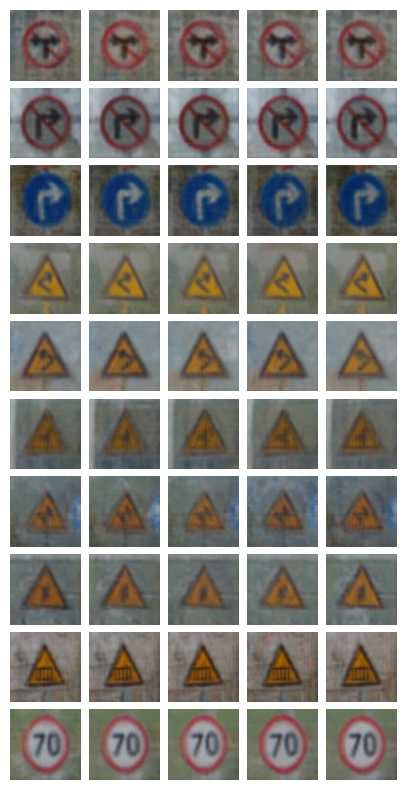

In [7]:
def generate_and_plot_images(model, device, num_labels, num_images=5):
    model.eval()
    fig, axes = plt.subplots(num_labels, num_images, figsize=(num_images * 1, num_labels * 1))
    
    for i in range(num_labels):
        for j in range(num_images):
            z = torch.randn(1, 128).to(device)
            label = torch.tensor([i]).to(device)  # Label desejada
            with torch.no_grad():
                image = model.decode(z, label)
            image = image.cpu().view(3, 75, 75)
            ax = axes[i, j]
            ax.imshow(image.permute(1, 2, 0))  # Ajustar a permutação para visualização
            ax.axis('off')
        axes[i, 0].set_ylabel(f'Label {i}')

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

generate_and_plot_images(model, device, num_labels=10)  